In [9]:
import os
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks, regularizers
from keras.layers import LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [10]:
seed_value = 42

os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [11]:
model_version = 'v6.0'

In [12]:
with open('data_schema.json', 'r') as f:
    config = json.load(f)
    
spectro_cols = config['spectro_cols']
photo_cols = config['photometry_cols']
generic_cols = config['generic_cols']
target_col = config['target_col']

In [13]:
df = pd.read_csv(f"data/processed/spectrometry_photometry.csv")

X = df[spectro_cols + photo_cols + generic_cols]
y = df[target_col]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed_value)

In [ ]:
# Step 1: Signed log transform to compress extreme values
def signed_log_transform(X):
    return np.sign(X) * np.log1p(np.abs(X))

X_train_log = signed_log_transform(X_train)
X_test_log = signed_log_transform(X_test)

# Step 2: Standardization for zero mean and unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_log)
X_test_scaled = scaler.transform(X_test_log)


In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
X_train_scaled.min(), X_train_scaled.max(), X_train_scaled.mean(), X_train_scaled.std()

(-312.68590659380294,
 384.37018907406116,
 -1.0057189023818205e-17,
 0.9999999999999994)

In [18]:
y_train.min(), y_train.max(), y_train.mean(), y_train.std()

(logM_star    6.00074
 dtype: float64,
 logM_star    12.46165
 dtype: float64,
 logM_star    10.598514
 dtype: float64,
 logM_star    0.657683
 dtype: float64)

In [18]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
activation = LeakyReLU()

# First Model: Spectroscopic Features + Photometric Features
full_input = keras.Input(shape=(X_train_scaled.shape[1]), name = 'full_input')
x = layers.Dense(128, activation=activation, name='Dense_64')(full_input)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation=activation, name='Dense_128')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(64, activation=activation, name='Dense_32')(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(1, name='logM_star')(x)

full_model = keras.Model(inputs=full_input, outputs=output, name='Full_Model')

optimizer = Adam(learning_rate=0.001)

full_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse', 'mape'])
full_model.summary()

Model: "Full_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 full_input (InputLayer)     [(None, 58)]              0         
                                                                 
 Dense_64 (Dense)            (None, 128)               7552      
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 Dense_128 (Dense)           (None, 256)               33024     
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 Dense_32 (Dense)            (None, 64)                16448     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0

In [22]:
history_full_model = full_model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_split=0.5, verbose=1)

Epoch 1/20
2443/2443 [==============================] - 15s 6ms/step - loss: 9.6762 - mae: 1.6529 - mse: 9.6762 - mape: 15.6832 - val_loss: 1.1398 - val_mae: 0.5163 - val_mse: 1.1398 - val_mape: 4.8585
Epoch 2/20
2443/2443 [==============================] - 14s 6ms/step - loss: 2.3614 - mae: 1.0717 - mse: 2.3614 - mape: 10.1411 - val_loss: 0.1837 - val_mae: 0.2126 - val_mse: 0.1837 - val_mape: 2.0509
Epoch 3/20
2443/2443 [==============================] - 14s 6ms/step - loss: 1.8106 - mae: 0.8846 - mse: 1.8106 - mape: 8.3729 - val_loss: 0.8041 - val_mae: 0.2102 - val_mse: 0.8041 - val_mape: 2.0211
Epoch 4/20
2443/2443 [==============================] - 15s 6ms/step - loss: 1.2981 - mae: 0.7580 - mse: 1.2981 - mape: 7.1742 - val_loss: 0.1612 - val_mae: 0.1950 - val_mse: 0.1612 - val_mape: 1.8763
Epoch 5/20
2443/2443 [==============================] - 15s 6ms/step - loss: 1.0552 - mae: 0.6494 - mse: 1.0552 - mape: 6.1454 - val_loss: 0.1235 - val_mae: 0.1956 - val_mse: 0.1235 - val_mape: 

In [23]:
y_pred_full = full_model.predict(X_test_scaled)

# Evaluate accuracy metrics
mae = mean_absolute_error(y_test, y_pred_full)
r2 = r2_score(y_test, y_pred_full)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_full))

print(f"Spectrometry and Photometry Model Evaluation:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

2094/2094 [==============================] - 3s 1ms/step
Spectrometry and Photometry Model Evaluation:
Mean Absolute Error (MAE): 0.0845
Root Mean Squared Error (RMSE): 0.1597
R² Score: 0.9409


In [27]:
y_test.shape, y_pred_full.shape

((67003, 1), (67003, 1))

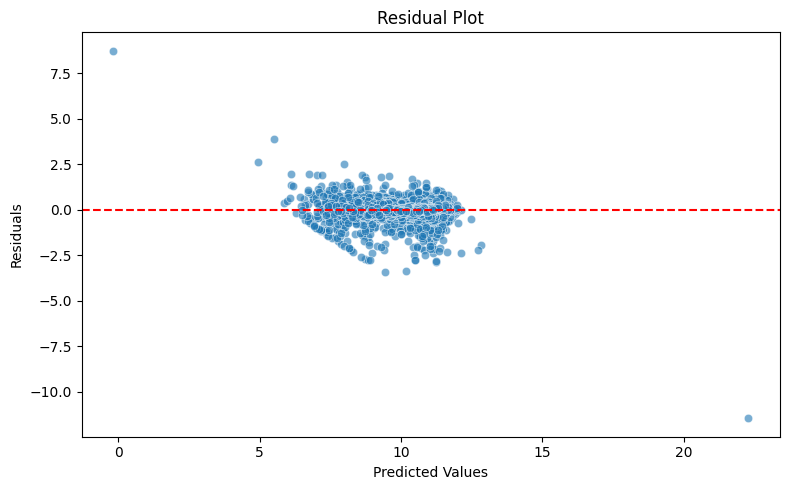

In [33]:

y_pred_flat = y_pred_full.ravel()
y_test_flat = y_test.iloc[:, 0].values.ravel()

residuals = y_test_flat - y_pred_flat

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred_flat, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.tight_layout()
plt.show()

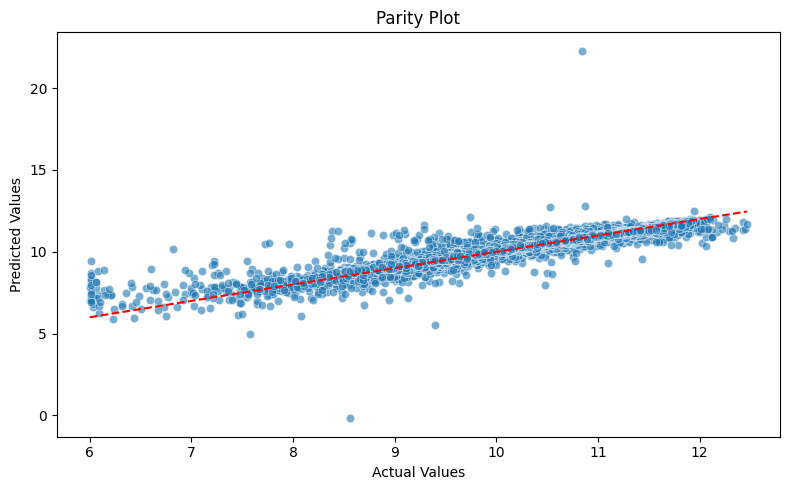

In [39]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test_flat, y=y_pred_flat, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Parity Plot")
plt.tight_layout()
plt.show()


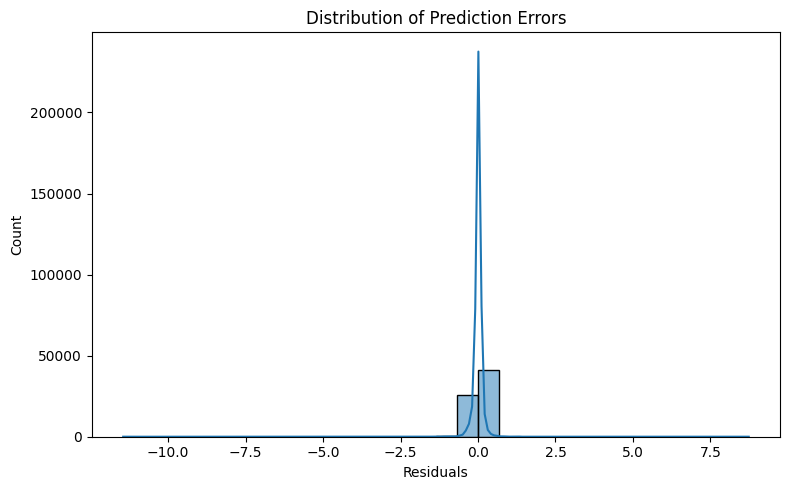

In [40]:
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel("Residuals")
plt.title("Distribution of Prediction Errors")
plt.tight_layout()
plt.show()


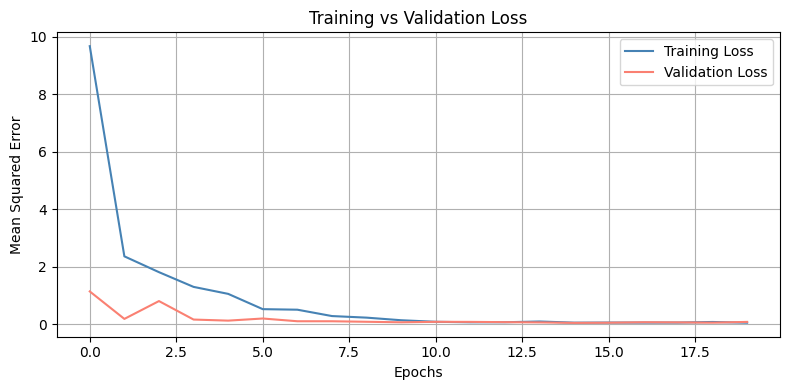

In [42]:
plt.figure(figsize=(8, 4))
plt.plot(history_full_model.history['loss'], label='Training Loss', color='steelblue')
plt.plot(history_full_model.history['val_loss'], label='Validation Loss', color='salmon')
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

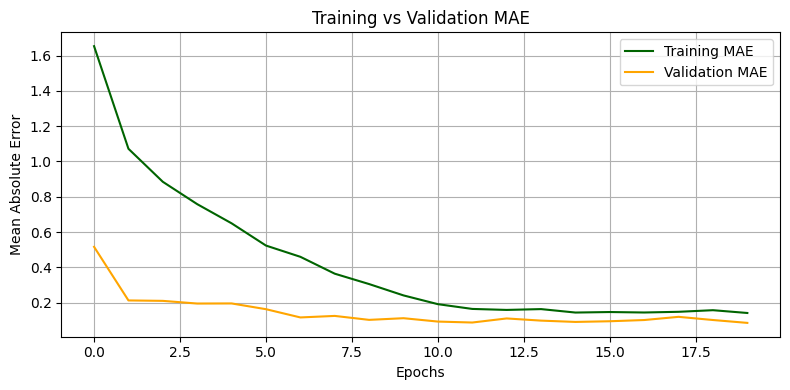

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(history_full_model.history['mae'], label='Training MAE', color='darkgreen')
plt.plot(history_full_model.history['val_mae'], label='Validation MAE', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.title("Training vs Validation MAE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()